In [167]:
from glob import glob
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd

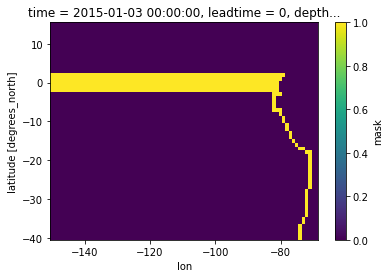

In [168]:
mask = xr.open_dataset('data/PATHWAY_MASK_REFORECAST_ZOS.nc').load().astype(float).sel(lat=slice(-40,15))
mask.mask.plot()

In [169]:
sshclim = [xr.open_dataset(p) for p in glob('data/S2S/CLIMATOLOGY/SSH*')]
sshclim = xr.concat(sshclim, 'leadtime').sortby('leadtime').transpose('leadtime','dayofyear','lat','lon').rename({'dslm':'ssh'})

sstclim = [xr.open_dataset(p) for p in glob('data/S2S/CLIMATOLOGY/SST*')]
sstclim = xr.concat(sstclim, 'leadtime').sortby('leadtime').transpose('leadtime','dayofyear','lat','lon')-273.15
sstclim = xe.Regridder(sstclim, xr.Dataset({'lat':(['lat'], sshclim.lat.values),'lon':(['lon'],sshclim.lon.values)}), method='bilinear')(sstclim.sst).ffill('lon')
sstclim = sstclim.where(~np.isnan(sshclim.ssh)).to_dataset(name='sst')
clims = xr.merge([sstclim,sshclim])


/home/lucas/miniconda3/envs/forecast/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [215]:
def load_reforecast(path):
    data = xr.open_mfdataset(path).load()
    data.coords['lon'] = (data.lon+180)%360-180
    data = data.sortby('lat').sortby('lon')
    data = data.sel(lat=slice(clims.lat.min(), clims.lat.max()),lon=slice(clims.lon.min(),clims.lon.max()))
    return data
    
    
def compute_anom(data, t, clims):
    anom1 = data.sel(time=t).drop('time').rename({'leadtime':'time'})
    anom1.coords['leadtime'] = ('time', anom1.time.data)
    anom1.coords['time'] = ('time', [pd.Timedelta(days=l.item())+t for l in anom1.leadtime])
    anom1 = anom1.convert_calendar('noleap').swap_dims({'time':'leadtime'})
    anom1.coords['dayofyear'] = ('time',anom1.time.dt.dayofyear.data)
    anom1 = xr.concat([anom1.sel(leadtime=lead)-clims.sel(dayofyear=dayofyear).sel(leadtime=lead) 
                        for dayofyear,lead in zip(anom1.dayofyear.values, anom1.leadtime.values)],
                        'leadtime')
    anom1 = anom1.rename({'ssh':'ssh_anomaly','sst':'sst_anomaly'}).drop('time').interpolate_na(dim='leadtime')
    anom1.coords['time'] = ('time', [t])
    return anom1

reforecasts = sorted(glob("data/S2S/reforecasts/*[!.nc]"))
DATA = []
for p in reforecasts:
    if p.split('-')[1]!='02' and p.split('-')[1]!='01':
        pass
    else:
        print(p)
        zos  = load_reforecast(p+'/merged.nc')
        sst  = load_reforecast(p+'/merged_SST_regrid.nc').ffill('lon')-273.15
        data = xr.merge([zos,sst]).rename({'dslm':'ssh'}).sortby('time').sortby('leadtime')
        data = xr.merge([data,xr.concat([compute_anom(data, t, clims) 
                                        for t in data.time.values],
                                        'time')])
        # data = data.convert_calendar('noleap')
        data_tropical = data.where(mask.tropical_mask==1).mean('lat').interpolate_na(dim='leadtime').dropna('lon')
        data_tropical.coords['index'] = ('lon',np.arange(len(data_tropical.lon)))
        data_tropical = data_tropical.swap_dims({'lon':'index'})
        
        data_coast    = data.where(mask.coastmask==1).mean('lon').interpolate_na(dim='leadtime').dropna('lat').sortby('lat', ascending=False)
        data_coast.coords['index'] = ('lat',np.arange(len(data_coast.lat))+data_tropical.index[-1].item()+1)    
        data_coast    = data_coast.swap_dims({'lat':'index'})
        
        broadcasted = xr.broadcast(data_tropical, data_coast)
        lon = broadcasted[0].lon
        lat = broadcasted[1].lat
            
        data_hovmoller = xr.concat([data_tropical.drop('lon'), data_coast.drop('lat')], 'index').sortby('index')
        data_hovmoller.coords['lon'] = ('index', lon.values)
        data_hovmoller.coords['lat'] = ('index', lat.values)
        data_hovmoller.to_netcdf(p+'/hovmoller.nc', mode='w')
    
#     DATA.append(data_hovmoller.drop('dayofyear').drop('depth'))
# print('Joining...')
# DATA = xr.concat(DATA,'time').sortby('time')
# DATA = DATA.sel(time=~((DATA.time.dt.month==2)&(DATA.time.dt.day==29)))
# DATA['lon'] = (DATA['lon']%180)-180
# DATA = DATA.drop_duplicates('time')#.resample({'time':'d'}).interpolate(kind='nearest')
# DATA = DATA.convert_calendar('noleap')
# DATA

data/S2S/reforecasts/2020-01-06
data/S2S/reforecasts/2020-01-09
data/S2S/reforecasts/2020-01-13
data/S2S/reforecasts/2020-01-16
data/S2S/reforecasts/2020-01-20
data/S2S/reforecasts/2020-01-23
data/S2S/reforecasts/2020-01-27
data/S2S/reforecasts/2020-01-30
data/S2S/reforecasts/2020-02-03
data/S2S/reforecasts/2020-02-06
data/S2S/reforecasts/2020-02-10
data/S2S/reforecasts/2020-02-13
data/S2S/reforecasts/2020-02-17
data/S2S/reforecasts/2020-02-20
data/S2S/reforecasts/2020-02-24
data/S2S/reforecasts/2020-02-27
data/S2S/reforecasts/2021-01-04
data/S2S/reforecasts/2021-01-07
data/S2S/reforecasts/2021-01-11
data/S2S/reforecasts/2021-01-14
data/S2S/reforecasts/2021-01-18
data/S2S/reforecasts/2021-01-21
data/S2S/reforecasts/2021-01-25
data/S2S/reforecasts/2021-01-28
data/S2S/reforecasts/2021-02-01
data/S2S/reforecasts/2021-02-04
data/S2S/reforecasts/2021-02-08
data/S2S/reforecasts/2021-02-11
data/S2S/reforecasts/2021-02-15
data/S2S/reforecasts/2021-02-18
data/S2S/reforecasts/2021-02-22
data/S2S

In [216]:
reforecasts = sorted(glob("data/S2S/reforecasts/*[!.nc]"))
DATA = []
for p in reforecasts:
    print(p)
    DATA.append(xr.open_dataset(p+'/hovmoller.nc'))
DATA = xr.concat(DATA, 'time').sortby('time')

data/S2S/reforecasts/2020-01-06
data/S2S/reforecasts/2020-01-09
data/S2S/reforecasts/2020-01-13
data/S2S/reforecasts/2020-01-16
data/S2S/reforecasts/2020-01-20
data/S2S/reforecasts/2020-01-23
data/S2S/reforecasts/2020-01-27
data/S2S/reforecasts/2020-01-30
data/S2S/reforecasts/2020-02-03
data/S2S/reforecasts/2020-02-06
data/S2S/reforecasts/2020-02-10
data/S2S/reforecasts/2020-02-13
data/S2S/reforecasts/2020-02-17
data/S2S/reforecasts/2020-02-20
data/S2S/reforecasts/2020-02-24
data/S2S/reforecasts/2020-02-27
data/S2S/reforecasts/2020-03-02
data/S2S/reforecasts/2020-03-05
data/S2S/reforecasts/2020-03-09
data/S2S/reforecasts/2020-03-12
data/S2S/reforecasts/2020-03-16
data/S2S/reforecasts/2020-03-19
data/S2S/reforecasts/2020-03-23
data/S2S/reforecasts/2020-03-26
data/S2S/reforecasts/2020-03-30
data/S2S/reforecasts/2020-04-02
data/S2S/reforecasts/2020-04-06
data/S2S/reforecasts/2020-04-09
data/S2S/reforecasts/2020-04-13
data/S2S/reforecasts/2020-04-16
data/S2S/reforecasts/2020-04-20
data/S2S

In [222]:

def synopanom(data2):
    data = data2.resample({'time':'D'}).mean().interpolate_na(dim='time', method='nearest')
    lowfreq_variability = data.resample({'time':'MS'}, loffset=pd.Timedelta(days=14)).mean()
    lowfreq_variability = lowfreq_variability.resample({'time':'D'}).interpolate(kind='cubic')
    lowfreq_variability = lowfreq_variability.reindex({'time':data2.time.values}, method='nearest')
    sst_synopanom = data2-lowfreq_variability
    return sst_synopanom
sst_synopanom = synopanom(DATA.sst).to_dataset(name='sst_synopanom')
ssh_synopanom = synopanom(DATA.ssh).to_dataset(name='ssh_synopanom')
DATA = xr.merge([DATA, sst_synopanom, ssh_synopanom])

In [226]:
for yr in range(2000,2022):
    DATA.sel(time=str(yr)).to_netcdf('data/S2S/HOVMOLLERS/reforecasts_Y'+str(yr)+'.nc', mode='w')